In [1]:
import pandas as pd
import requests
import plotly.graph_objects as go

### ProductId's
- Tomate Verde = 842
- Aguacate Hass = 133

In [15]:
base_url = "https://www.economia-sniim.gob.mx/Nuevo/Consultas/MercadosNacionales/PreciosDeMercado/Agricolas/ResultadosConsultaFechaFrutasYHortalizas.aspx"
params = {
    "fechaInicio": "01/01/2025",
    
    "fechaFinal": "10/01/2026",
    "ProductoId": 133,
    "OrigenId": -1,
    "Origen": "Todos",
    "DestinoId": -1,
    "Destino": "Todos",
    "PreciosPorId": 2,
    "RegistrosPorPagina": 2000,
}
response = requests.get(base_url, params=params)
url = response.url

In [16]:
tables = pd.read_html(url)

In [17]:
len(tables)

14

In [18]:
def formatTable(df: pd.DataFrame):
    df = df.map(
        lambda x: x.encode("latin1").decode("utf-8") if isinstance(x, str) else x
    )
    df = df[df[0] != "Frutas de Temporada"].reset_index(drop=True)
    df.columns = df.iloc[0]
    df = df.iloc[1:].reset_index(drop=True)
    df = df.rename(columns={
        "Fecha": "date",
        "Presentación": "presentation",
        "Origen": "origin",
        "Destino": "destination",
        "Precio Mín": "min_price",
        "Precio Max": "max_price",
        "Precio Frec": "avg_price",
        "Obs.": "notes"
    })
    df["date"] = pd.to_datetime(df["date"], format="%d/%m/%Y", errors="coerce")
    df = df.dropna(subset=["date"]).reset_index(drop=True)
    price_cols = ["min_price", "max_price", "avg_price"]
    df[price_cols] = df[price_cols].astype(float)

    return df


In [19]:
data = formatTable(tables[8])
data.head()

,date,presentation,origin,destination,min_price,max_price,avg_price,notes
0,2025-01-02,Kilogramo,Jalisco,Aguascalientes: Centro Comercial Agropecuario ...,42.0,46.0,44.0,NaN
1,2025-01-02,Kilogramo,Michoacán,Aguascalientes: Centro Comercial Agropecuario ...,58.0,62.0,60.0,NaN
2,2025-01-03,Kilogramo,Jalisco,Aguascalientes: Centro Comercial Agropecuario ...,42.0,46.0,44.0,NaN
3,2025-01-03,Kilogramo,Michoacán,Aguascalientes: Centro Comercial Agropecuario ...,58.0,62.0,60.0,NaN
4,2025-01-06,Kilogramo,Jalisco,Aguascalientes: Centro Comercial Agropecuario ...,42.0,46.0,44.0,NaN


In [20]:
data.shape

(2000, 8)

In [21]:
data["origin"].unique()

array(['Jalisco', 'Michoacán', 'Nacional', 'Aguascalientes',
       'Distrito Federal', 'Puebla'], dtype=object)

In [22]:
print(data.head())

0       date presentation     origin  \
0 2025-01-02    Kilogramo    Jalisco   
1 2025-01-02    Kilogramo  Michoacán   
2 2025-01-03    Kilogramo    Jalisco   
3 2025-01-03    Kilogramo  Michoacán   
4 2025-01-06    Kilogramo    Jalisco   

0                                        destination  min_price  max_price  \
0  Aguascalientes: Centro Comercial Agropecuario ...       42.0       46.0   
1  Aguascalientes: Centro Comercial Agropecuario ...       58.0       62.0   
2  Aguascalientes: Centro Comercial Agropecuario ...       42.0       46.0   
3  Aguascalientes: Centro Comercial Agropecuario ...       58.0       62.0   
4  Aguascalientes: Centro Comercial Agropecuario ...       42.0       46.0   

0  avg_price notes  
0       44.0   NaN  
1       60.0   NaN  
2       44.0   NaN  
3       60.0   NaN  
4       44.0   NaN  


In [23]:
def plot_prices_single_origin(df, origin, destinations=None, price_type='avg'):
    """
    Plot prices for a single origin and one or multiple destinations.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns ['date', 'origin', 'destination', 'min_price', 'max_price', 'avg_price']
        origin (str): The origin to filter
        destinations (list or str, optional): Destination(s) to filter. If None, plot all.
        price_type (str): 'min', 'avg', or 'max'
    """
    # Filter by origin
    df_filtered = df[df['origin'] == origin].copy()
    
    # Filter by destination if provided
    if destinations is not None:
        if isinstance(destinations, str):
            destinations = [destinations]
        df_filtered = df_filtered[df_filtered['destination'].isin(destinations)]
    
    # Ensure date is datetime
    df_filtered['date'] = pd.to_datetime(df_filtered['date'])
    
    fig = go.Figure()
    
    # If multiple destinations, plot only avg
    if destinations is not None and len(destinations) > 1:
        df_grouped = df_filtered.groupby('date')[f'{price_type}_price'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=df_grouped['date'],
            y=df_grouped[f'{price_type}_price'],
            mode='lines+markers',
            name=f'{price_type.capitalize()} Price (Avg of Destinations)',
            line=dict(color='yellow')
        ))
    else:
        # Plot each destination separately
        for dest in df_filtered['destination'].unique():
            df_dest = df_filtered[df_filtered['destination'] == dest]
            fig.add_trace(go.Scatter(
                x=df_dest['date'],
                y=df_dest[f'{price_type}_price'],
                mode='lines+markers',
                name=f'{dest} ({price_type})'
            ))
    
    # Update layout
    fig.update_layout(
        title=f"{price_type.capitalize()} Prices from {origin}",
        xaxis_title="Date",
        yaxis_title="Price",
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=True, gridcolor='gray'),
        yaxis=dict(showgrid=True, gridcolor='gray')
    )
    
    fig.show()

def plot_prices_multiple_origins(df, origins, price_type='avg'):
    """
    Plot prices for multiple origins. If multiple destinations on same day, average the prices.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns ['date', 'origin', 'destination', 'min_price', 'max_price', 'avg_price']
        origins (list): List of origins to plot
        price_type (str): 'min', 'avg', or 'max'
    """
    df['date'] = pd.to_datetime(df['date'])
    fig = go.Figure()
    
    for origin in origins:
        df_origin = df[df['origin'] == origin]
        # Average prices by date across destinations
        df_grouped = df_origin.groupby('date')[f'{price_type}_price'].mean().reset_index()
        fig.add_trace(go.Scatter(
            x=df_grouped['date'],
            y=df_grouped[f'{price_type}_price'],
            mode='lines+markers',
            name=f'{origin} ({price_type})'
        ))
    
    # Update layout
    fig.update_layout(
        title=f"{price_type.capitalize()} Prices for Multiple Origins",
        xaxis_title="Date",
        yaxis_title="Price",
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=True, gridcolor='gray'),
        yaxis=dict(showgrid=True, gridcolor='gray')
    )
    
    fig.show()


In [31]:
def plot_global_average_prices(df, show_actual_min_max=True):
    """
    Plot global average prices across all origins and destinations, with optional actual min/max per day.
    
    Parameters:
        df (pd.DataFrame): DataFrame with columns ['date', 'min_price', 'max_price', 'avg_price']
        show_actual_min_max (bool): Whether to show actual min/max observed per day
    """
    # Ensure date is datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Group by date and calculate average prices
    df_avg = df.groupby('date')[['min_price', 'avg_price', 'max_price']].mean().reset_index()
    
    fig = go.Figure()
    
    # Plot averaged lines
    fig.add_trace(go.Scatter(
        x=df_avg['date'],
        y=df_avg['min_price'],
        mode='lines+markers',
        name='Average Min Price',
        line=dict(color='cyan')
    ))
    
    fig.add_trace(go.Scatter(
        x=df_avg['date'],
        y=df_avg['avg_price'],
        mode='lines+markers',
        name='Average Avg Price',
        line=dict(color='yellow')
    ))
    
    fig.add_trace(go.Scatter(
        x=df_avg['date'],
        y=df_avg['max_price'],
        mode='lines+markers',
        name='Average Max Price',
        line=dict(color='red')
    ))
    
    # Optionally add actual min and max prices per day
    if show_actual_min_max:
        # Calculate actual min and max across all origins/destinations
        df_actual_min = df.groupby('date')['min_price'].min().reset_index(name='actual_min')
        df_actual_max = df.groupby('date')['max_price'].max().reset_index(name='actual_max')
        
        fig.add_trace(go.Scatter(
            x=df_actual_min['date'],
            y=df_actual_min['actual_min'],
            mode='lines+markers',
            name='Actual Min Price',
            line=dict(color='cyan', dash='dot')
        ))
        
        fig.add_trace(go.Scatter(
            x=df_actual_max['date'],
            y=df_actual_max['actual_max'],
            mode='lines+markers',
            name='Actual Max Price',
            line=dict(color='red', dash='dot')
        ))
    
    # Layout
    fig.update_layout(
        title="Global Prices Across All Origins and Destinations",
        xaxis_title="Date",
        yaxis_title="Price",
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        xaxis=dict(showgrid=True, gridcolor='gray'),
        yaxis=dict(showgrid=True, gridcolor='gray')
    )
    
    fig.show()


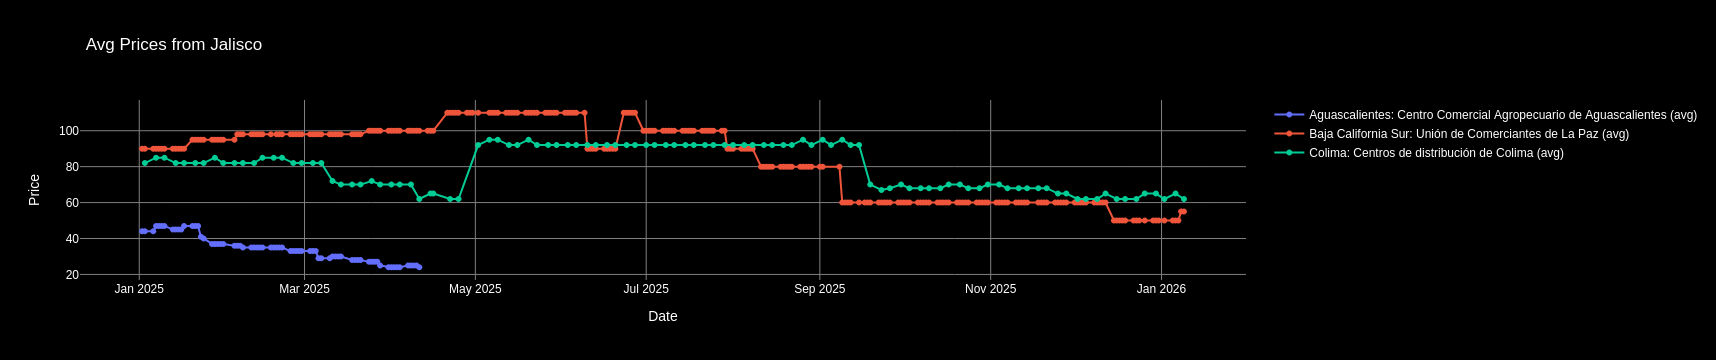

In [32]:
plot_prices_single_origin(data, "Jalisco",  destinations=None, price_type='avg')

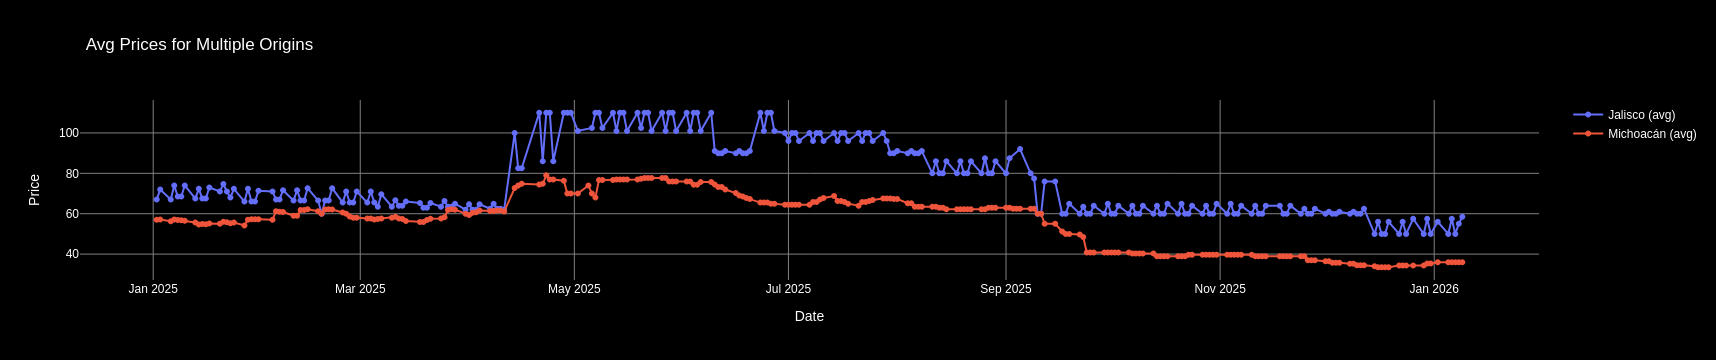

In [33]:
plot_prices_multiple_origins(data, ['Jalisco', 'Michoacán'], price_type='avg')

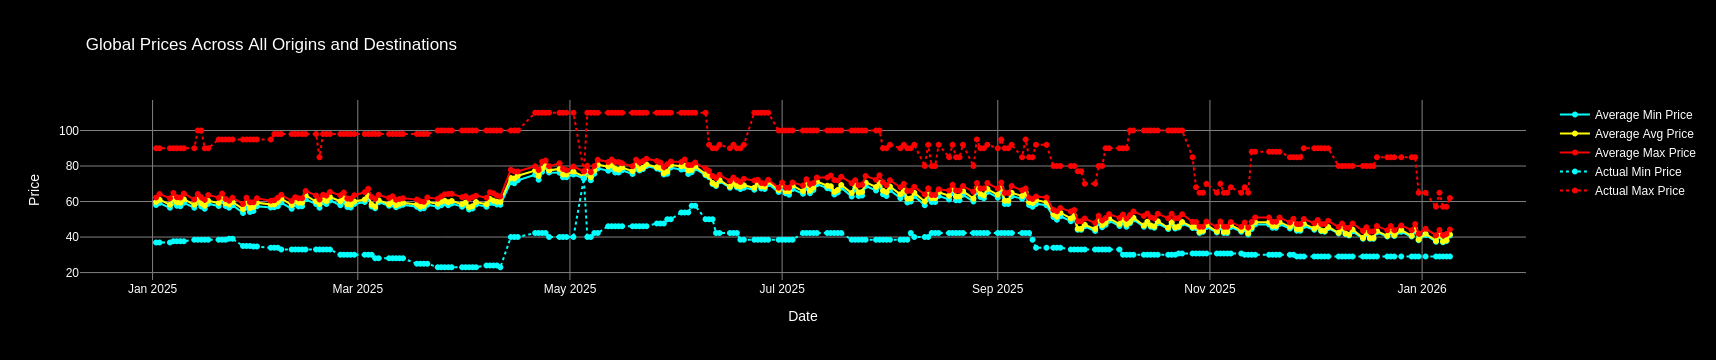

In [34]:
plot_global_average_prices(data, True )